## Analyze e2e latencies for the single_client_e2e experiment

In [ ]:
import numpy as np
import glob

def get_append_metrics(path):
    file_pattern = path + "append_metrics*.csv"

    total_throughput = 0
    latency_values = []

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]
            for line in lines:
                parts = line.strip().split(',')
                gsn, latency, throughput = int(parts[0]), float(parts[1]), float(parts[2])
                latency_values.append(latency)
            
            total_throughput += throughput

    latency_array = np.array(latency_values)

    mean_latency = np.mean(latency_array)
    p50_latency = np.percentile(latency_array, 50)
    p99_latency = np.percentile(latency_array, 99)

    print("results for computation time " + path.split("_")[-1].split("/")[0] + " us")
    print("statistic/metric, latency (us)")
    print(f"mean, {mean_latency:.2f}")
    print(f"p50, {p50_latency:.2f}")
    print(f"p99, {p99_latency:.2f}")
    print(f"total throughput, {total_throughput:.2f}")

    return int(path.split("_")[-1].split("/")[0]), mean_latency, total_throughput 

def get_e2e_metrics(path):
    file_pattern = path + "e2e_metrics*.csv"

    delivery_latency_values = []
    compute_latency_values = []
    confirmation_latency_values = []
    e2e_latency_values = []
    queuing_delay_values = []

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]
            for line in lines:
                parts = line.strip().split(',')
                delivery, confirm, compute, e2e, queuing_delay = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4]), float(parts[5])
                delivery_latency_values.append(delivery)
                compute_latency_values.append(compute)
                confirmation_latency_values.append(confirm)
                e2e_latency_values.append(e2e)
                queuing_delay_values.append(queuing_delay)

    
    delivery_latency_array = np.array(delivery_latency_values)
    compute_latency_array = np.array(compute_latency_values)
    confirmation_latency_array = np.array(confirmation_latency_values)
    e2e_latency_array = np.array(e2e_latency_values)
    queuing_delay_array = np.array([x for x in queuing_delay_values if x > 0])

    print("statistic/metric, delivery latency (us), compute latency (us), confirm latency (us), e2e latency (us), queuing delay (us)")
    print(f"mean, {np.mean(delivery_latency_array):.2f}, {np.mean(compute_latency_array):.2f}, {np.mean(confirmation_latency_array):.2f}, {np.mean(e2e_latency_array):.2f}, {np.mean(queuing_delay_array):.2f}")
    print(f"std, {np.std(delivery_latency_array):.2f}, {np.std(compute_latency_array):.2f}, {np.std(confirmation_latency_array):.2f}, {np.std(e2e_latency_array):.2f}, {np.std(queuing_delay_array):.2f}")
    print(f"p50, {np.percentile(delivery_latency_array, 50):.2f}, {np.percentile(compute_latency_array, 50):.2f}, {np.percentile(confirmation_latency_array, 50):.2f}, {np.percentile(e2e_latency_array, 50):.2f}, {np.percentile(queuing_delay_array, 50):.2f}")
    print(f"p99, {np.percentile(delivery_latency_array, 99):.2f}, {np.percentile(compute_latency_array, 99):.2f}, {np.percentile(confirmation_latency_array, 99):.2f}, {np.percentile(e2e_latency_array, 99):.2f}, {np.percentile(queuing_delay_array, 99):.2f}")

    return int(path.split("_")[-1].split("/")[0]), np.mean(delivery_latency_array), np.mean(compute_latency_array), np.mean(confirmation_latency_array), np.mean(e2e_latency_array), np.mean(queuing_delay_array)

In [ ]:
path = "../results/*"

for dir in glob.glob(path + "*/"):
    get_append_metrics(dir)
    get_e2e_metrics(dir)


In [ ]:
import re
import pandas as pd

# Input data
data = """
PASTE DATA FROM OUTPUT ABOVE
"""

# Split data into lines
lines = data.splitlines()

# Parsing logic
results = []
current_time = None
append_latency = None

for i, line in enumerate(lines):
    line = line.strip()
    # Detect computation time
    if line.startswith("results for computation time"):
        match = re.search(r"computation time (\d+) us", line)
        if match:
            current_time = int(match.group(1))
    # Extract append latency (first "latency (us)" mean value)
    elif "statistic/metric, latency (us)" in line:
        append_line = lines[i + 1]  # Look at the next line
        append_match = re.match(r"mean,\s*([\d.]+)", append_line)
        if append_match:
            append_latency = float(append_match.group(1))
    # Extract other latencies (mean values)
    elif line.startswith("mean,") and current_time is not None:
        parts = line.split(",")
        if len(parts) == 6:  # Ensure correct format
            delivery_latency, compute_latency, confirm_latency, e2e_latency, queueing_delay = map(float, parts[1:])
            results.append({
                "computation_time": current_time,
                "append_latency": append_latency,
                "delivery_latency": delivery_latency,
                "compute_latency": compute_latency,
                "confirm_latency": confirm_latency,
                "e2e_latency": e2e_latency,
                "queueing_delay": queueing_delay,
            })

# Create a DataFrame
df = pd.DataFrame(results)

df.to_csv("output.csv", index=False)

# Print the CSV content
print(df.to_csv(index=False))

### Analyze order server log from the reconfiguration experiment

In [ ]:
import re
import matplotlib.pyplot as plt
from datetime import datetime

# File path
log_file = "../results/reconfig_1000/order-0.log"

# Regex patterns
tput_pattern = r"\[real-time tput\]: (\d+) ops/sec"
timestamp_pattern = r"(\d{2}:\d{2}:\d{2}\.\d{6})"

# Data storage
timestamps = []
tput_values = []
shard_join_request = []
shard_notified_to_be_added = []
shard_notified_to_be_removed = []
first_cut_committed = []
last_cut_committed = []
shard_leave_request = []

# Parse the log file
with open(log_file, "r") as f:
    for line in f:
        # Extract real-time throughput
        tput_match = re.search(tput_pattern, line)
        timestamp_match = re.search(timestamp_pattern, line)
        
        if tput_match and timestamp_match:
            tput_values.append(int(tput_match.group(1)))
            timestamps.append(datetime.strptime(timestamp_match.group(1), "%H:%M:%S.%f"))
        
        # Extract events for annotation
        if "Shard 1 to be added in next avl window" in line:
            shard_join_request.append(timestamp_match.group(1))

        if shard_notified_to_be_added == [] and "shardQuotas:<key:2" in line:
            shard_notified_to_be_added.append(timestamp_match.group(1))
        
        if first_cut_committed == [] and "cut:<key:2" in line:
            first_cut_committed.append(timestamp_match.group(1))
        
        if last_cut_committed == [] and "Replica 2 finalized" in line:
            last_cut_committed.append(timestamp_match.group(1))

        if "Shard 1 to be finalized in next avl window" in line:
            shard_leave_request.append(timestamp_match.group(1))

        if "Incrementing view ID because shardFinalized: true" in line:
            shard_notified_to_be_removed.append(timestamp_match.group(1))


# Convert timestamps to seconds since the start
start_time = timestamps[0]
time_in_seconds = [(ts - start_time).total_seconds() for ts in timestamps]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_in_seconds, tput_values, label="Throughput (ops/sec)", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Throughput (ops/sec)")
plt.title("Real-time Throughput vs Time")
plt.grid()

# Event times
shard_join_request = (datetime.strptime(shard_join_request[0], "%H:%M:%S.%f") - start_time).total_seconds()
shard_notified_to_be_added_time = (datetime.strptime(shard_notified_to_be_added[0], "%H:%M:%S.%f") - start_time).total_seconds()
first_cut_committed_time = (datetime.strptime(first_cut_committed[0], "%H:%M:%S.%f") - start_time).total_seconds()
shard_leave_request_time = (datetime.strptime(shard_leave_request[0], "%H:%M:%S.%f") - start_time).total_seconds()
shard_notified_to_be_removed_time = (datetime.strptime(shard_notified_to_be_removed[0], "%H:%M:%S.%f") - start_time).total_seconds()
last_cut_committed_time = (datetime.strptime(last_cut_committed[0], "%H:%M:%S.%f") - start_time).total_seconds()

# Add vertical lines for events
plt.axvline(shard_join_request, color="red", linestyle="--", alpha=0.7, label="shard requests to join")
plt.axvline(shard_notified_to_be_added_time, color="green", linestyle="--", alpha=0.7, label="shard notified about addition window")
plt.axvline(first_cut_committed_time, color="purple", linestyle="--", alpha=0.7, label="first cut committed from new shard")
plt.axvline(shard_leave_request_time, color="orange", linestyle="--", alpha=0.7, label="shard requests to leave")
plt.axvline(shard_notified_to_be_removed_time, color="brown", linestyle="--", alpha=0.7, label="shard notified about removal window")
plt.axvline(last_cut_committed_time, color="black", linestyle="--", alpha=0.7, label="last cut committed from leaving shard")

# Zoom in to the relevant range (adjust as needed)
# plt.xlim(22.8, 23.5)
# plt.xlim(10, 65)
# plt.xlim(51, 55)

# Add legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Events")

# Adjust layout to ensure the legend doesn't overlap with the plot
plt.tight_layout()

# Save the plot
plt.savefig("adding_reconfig_throughput_annotated.png", dpi=600)

plt.show()


## Analyze script for lagfix expt

In [ ]:
import re
import math

def find_nearest_multiple_of_3(number):
    return math.ceil(number / 3) * 3
    
def process_logs(logfile1, logfile2, logfile3):
    # Step 1: Extract the number from logfile1
    with open(logfile1, 'r') as file1:
        for line in file1:
            match = re.search(r"burst record with lsn (\d+)", line)
            if match:
                number = int(match.group(1))
                y = find_nearest_multiple_of_3(number)
                break
        else:
            raise ValueError("No 'burst record with lsn' found in logfile1")
    
    # Step 2: Locate and fetch lines from logfile2
    with open(logfile2, 'r') as file2:
        lines = file2.readlines()
    
    target_index = None
    for i, line in enumerate(lines):
        if f"cut:{y} cut:0" in line:
            target_index = i
            break
    
    if target_index is None:
        raise ValueError(f"No line containing 'cut:{y} cut:0' found in logfile2")
    
    # Fetch 2000 lines before and after
    start = max(0, target_index - 200)
    end = min(len(lines), target_index + 200)
    selected_lines = lines[start:end]
    
    # Step 3: Write to logfile3
    with open(logfile3, 'w') as file3:
        file3.writelines(selected_lines)

    return y



In [ ]:
logfile1 = "../results/lagfix/data-0-0.log"
logfile2 = "../results/lagfix/order-0.log"
logfile3 = "output.log"

y = process_logs(logfile1, logfile2, logfile3)

In [ ]:
import re

def extract_events(log_file, y):
    shard_0_cuts = []
    shard_1_cuts = []
    
    lagfix_detected = []
    lagfix_notified = []
    lagfix_resolved = []
    burst_start = []

    # Generic pattern for timestamps
    timestamp_pattern = r"(\d{2}:\d{2}:\d{2}\.\d{6})"

    with open(log_file, 'r') as file:
        for line in file:
            # Check for shard 0 cuts
            match_shard_0 = re.search(fr"{timestamp_pattern} cut:(\d+) cut:0", line)
            if match_shard_0:
                timestamp, cut = match_shard_0.groups()
                shard_0_cuts.append((timestamp, int(cut)))

            # Check for shard 1 cuts
            match_shard_1 = re.search(fr"{timestamp_pattern} localReplicaID:1 cut:0 cut:(\d+)", line)
            if match_shard_1:
                timestamp, cut = match_shard_1.groups()
                shard_1_cuts.append((timestamp, int(cut)))

            if burst_start == [] and "cut:" + str(y) + " cut:0" in line:
                burst_start.append(re.search(timestamp_pattern, line).group(1))

            if burst_start != [] and lagfix_detected == [] and "significant lag in cuts:" in line:
                lagfix_detected.append(re.search(timestamp_pattern, line).group(1))

            if burst_start != [] and lagfix_notified == [] and "adjustmentSignal:" in line:
                lagfix_notified.append(re.search(timestamp_pattern, line).group(1))
            
            if burst_start != [] and lagfix_resolved == [] and "fixedLag:true" in line:
                lagfix_resolved.append(re.search(timestamp_pattern, line).group(1))


    return shard_0_cuts, shard_1_cuts, lagfix_detected, lagfix_notified, lagfix_resolved, burst_start


# Example usage
log_file = "output.log"
shard_0_cuts, shard_1_cuts, lagfix_detected, lagfix_notified, lagfix_resolved, burst_start = extract_events(log_file, y)




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta
from matplotlib.ticker import MultipleLocator, MaxNLocator, FuncFormatter


def parse_timestamp(timestamp):
    return datetime.strptime(timestamp, "%H:%M:%S.%f")


def plot_events_zoomed(
    shard_0_cuts, shard_1_cuts, lagfix_detected, lagfix_notified, lagfix_resolved, burst_start, zoom_event="Lag Detected", zoom_window_ms=100
):
    # Convert timestamps to datetime objects
    shard_0_times = [parse_timestamp(t) for t, _ in shard_0_cuts]
    shard_0_values = [1 for _ in shard_0_cuts]  # Level 1 for Shard 0

    shard_1_times = [parse_timestamp(t) for t, _ in shard_1_cuts]
    shard_1_values = [2 for _ in shard_1_cuts]  # Level 2 for Shard 1

    # Parse event timestamps
    event_times = {
        "Lag Detected": [parse_timestamp(lagfix_detected[0])] if lagfix_detected else [],
        "Lag Notified": [parse_timestamp(lagfix_notified[0])] if lagfix_notified else [],
        "Lag Resolved": [parse_timestamp(lagfix_resolved[0])] if lagfix_resolved else [],
        "Burst Start": [parse_timestamp(burst_start[0])] if burst_start else [],
    }

    # Event colors for differentiation
    event_colors = {
        "Lag Detected": "red",
        "Lag Notified": "purple",
        "Lag Resolved": "green",
        "Burst Start": "brown",
    }

    # Find the minimum timestamp across all events and cuts
    all_times = shard_0_times + shard_1_times
    for times in event_times.values():
        all_times.extend(times)

    min_timestamp = min(all_times)

    # Convert all timestamps to relative time (milliseconds since min_timestamp)
    def to_relative_ms(time):
        return (time - min_timestamp).total_seconds() * 1000

    shard_0_times_rel = [to_relative_ms(t) for t in shard_0_times]
    shard_1_times_rel = [to_relative_ms(t) for t in shard_1_times]

    # Parse event times as relative times
    event_times_rel = {
        event_name: [to_relative_ms(t) for t in times]
        for event_name, times in event_times.items()
    }

    # Determine the time range for zooming
    if zoom_event not in event_times_rel or not event_times_rel[zoom_event]:
        print(f"No event found for {zoom_event}.")
        return

    zoom_time = event_times_rel[zoom_event][0]
    zoom_start = zoom_time - zoom_window_ms
    zoom_end = zoom_time + zoom_window_ms

    # Filter data for the zoomed time range
    shard_0_times_zoomed = [t for t in shard_0_times_rel if zoom_start <= t <= zoom_end]
    shard_1_times_zoomed = [t for t in shard_1_times_rel if zoom_start <= t <= zoom_end]

    # Start plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot cut points for Shard 0 with stacking
    ax.scatter(shard_0_times_zoomed, [1 + 0.05 * i for i in range(len(shard_0_times_zoomed))], label="Shard 0 Cuts", color="blue", marker="o", s=40, alpha=0.6)

    # Plot cut points for Shard 1 with stacking
    ax.scatter(shard_1_times_zoomed, [2 + 0.05 * i for i in range(len(shard_1_times_zoomed))], label="Shard 1 Cuts", color="orange", marker="o", s=40, alpha=0.6)

    # Plot vertical lines for events within the zoom window
    for event_name, times in event_times_rel.items():
        for time in times:
            if zoom_start <= time <= zoom_end:
                ax.axvline(time, linestyle="--", label=event_name, color=event_colors[event_name], alpha=0.7)

    # Adjust x-axis for 1 ms ticks
    ax.xaxis.set_major_locator(MultipleLocator(1))  # 1 ms ticks
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))  # Show milliseconds as integers

    # Adjust number of ticks on the x-axis
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10, prune='both'))  # Use nbins to control tick density

    # Set the x-limits to zoom in on the window
    ax.set_xlim(zoom_start, zoom_end)

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=0)

    # Adjust y-axis
    ax.set_yticks([1, 2])
    ax.set_yticklabels(["Shard 0", "Shard 1"])

    # Add labels and legend
    ax.set_xlabel("Time (ms relative to min timestamp)")
    ax.set_ylabel("Shards")
    ax.set_title(f"Zoomed View: {zoom_event} (±{zoom_window_ms} ms)")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Legend", shadow=True)

    # Show the plot
    plt.tight_layout()
    plt.savefig("output.png", dpi=600)


# Example usage (assuming shard_0_cuts, shard_1_cuts, lagfix_detected, lagfix_notified, lagfix_resolved, burst_start are defined)
plot_events_zoomed(shard_0_cuts, shard_1_cuts, lagfix_detected, lagfix_notified, lagfix_resolved, burst_start, zoom_event="Burst Start", zoom_window_ms=20)


## Analyze script for the aggresive lagfix vs no lagfix latency plots

In [ ]:
import numpy as np
import glob

def get_append_metrics_for_lagfix(path):
    file_pattern = path + "append_latency_timestamp_0.csv"
    latency_values = {}
    gsns = []

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]  # Skip the header
            for line in lines:
                parts = line.strip().split(',')
                gsn, timestamp, latency = int(parts[0]), parts[1], int(parts[2])
                latency_values[gsn] = [latency, timestamp]

    client_file = path + "client_node13_0.log"
    with open(client_file, 'r') as f:
        log_data = f.read()
        for line in log_data.splitlines():
            if "gsn: " in line:
                try:
                    gsn = int(line.split()[-1])  
                    gsns.append(gsn)
                except ValueError:
                    print(f"Skipping invalid GSN: {line.split()[-1]}")

    gsns.sort()
    return latency_values, gsns

# CONFIGURE PATH HERE (without or aggressive)
path = "../results/lagfix/"
latency_values, gsns = get_append_metrics_for_lagfix(path)

latency_array = np.array([latency_values[gsn][0] for gsn in latency_values])
mean_latency = np.mean(latency_array)
p99_latency = np.percentile(latency_array, 99)

print(f"Mean latency: {mean_latency:.2f} us")
print(f"P99 latency: {p99_latency:.2f} us")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
latency_times = []
latencies = []
for gsn, (latency, timestamp) in latency_values.items():
    latency_times.append(datetime.strptime(timestamp, "%H:%M:%S.%f"))
    latencies.append(latency)

df = pd.DataFrame({
    'time': latency_times,
    'latency': latencies
})

df = df.sort_values(by='time')

# CONFIGURE WINDOW SIZE HERE
window_size = 10  # Set the window size for the moving average
df['moving_avg'] = df['latency'].rolling(window=window_size, min_periods=1).mean()

min_time = df['time'].min()
df['relative_time_ms'] = (df['time'] - min_time).dt.total_seconds() * 1000

# CONFIGURE ZOOM IN PERIOD HERE
start_time = datetime.strptime(latency_values[gsns[0]][1], "%H:%M:%S.%f") - timedelta(milliseconds=100)  
end_time = datetime.strptime(latency_values[gsns[-1]][1], "%H:%M:%S.%f") + timedelta(milliseconds=100)  

df_zoomed = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

plt.figure(figsize=(10, 6))
plt.plot(df_zoomed['relative_time_ms'], df_zoomed['moving_avg'], label=f'Moving Average (window={window_size})', color='blue', linewidth=2)


start_time_relative = (datetime.strptime(latency_values[gsns[0]][1], "%H:%M:%S.%f") - min_time).total_seconds() * 1000
end_time_relative = (datetime.strptime(latency_values[gsns[-1]][1], "%H:%M:%S.%f") - min_time).total_seconds() * 1000
plt.axvline(x=start_time_relative, color='green', linestyle=':', label=f'burst start time')
plt.axvline(x=end_time_relative, color='red', linestyle=':', label=f'burst end time')


plt.xlabel('Time (ms)')
plt.ylabel('Latency (us)')
plt.title('Latency Over Time with Moving Average')
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output.png", dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latency_vs_gsn(latency_values, gsns):
    sequence_numbers = list(latency_values.keys())
    latencies = [latency_values[gsn][0] for gsn in sequence_numbers]

    burst_start_gsn = gsns[0]
    burst_end_gsn = gsns[-1]
    
    start_index = sequence_numbers.index(burst_start_gsn)
    end_index = sequence_numbers.index(burst_end_gsn)
    
    # CONFIGURE WINDOW SIZE HERE
    window_start = max(start_index - 50, 0)
    window_end = min(end_index + 50, len(sequence_numbers) - 1)

    plt.figure(figsize=(12, 6))
    plt.plot(sequence_numbers[window_start:window_end+1], latencies[window_start:window_end+1], linestyle='-', label="Latency")

    plt.axvline(x=sequence_numbers[start_index], color='green', linestyle='--', label="Burst Start (GSN)")
    plt.axvline(x=sequence_numbers[end_index], color='purple', linestyle='--', label="Burst End (GSN)")

    plt.xlabel("GSN (Sequence Number)")
    plt.ylabel("Latency (us)")
    plt.title("Impact of bursts on latency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("latency_vs_gsn.png", dpi=600)

plot_latency_vs_gsn(latency_values, gsns)


## Analyze script for quota change experiment

In [ ]:
## Find burst start lcn and wn

import re

def extract_burst_cut_and_window(log_file_path):    
    pattern = r"burst local cut number (\d+), window num (\d+)"
    with open(log_file_path, "r") as file:
        log_content = file.read()
    matches = re.findall(pattern, log_content)

    if matches:
        for match in matches:
            return match[0], match[1]
    else:
        return None

# CONFIGURE PATH HERE
logfile = "../results/qc/data-0-0.log"
burst_cut_num, window_num = extract_burst_cut_and_window(logfile)
print(f"Burst cut number: {burst_cut_num}, Window number: {window_num}")


In [ ]:
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Helper function to parse timestamps
def parse_timestamp(ts):
    return datetime.strptime(ts, "%H:%M:%S.%f")

# File path
log_file = "../results/qc/order-0.log"

# Regex patterns
tput_pattern = r"\[real-time tput\]: (\d+) ops/sec"
total_tput_pattern = r"\[real-time total tput\]: (\d+) ops/sec"
timestamp_pattern = r"(\d{2}:\d{2}:\d{2}\.\d{6})"
cut_pattern = rf"{timestamp_pattern} cut:(\d+) cut:(\d+)"
quota_change_pattern = r"shardQuotas:<key:0 value:(\d+) > shardQuotas:<key:1 value:(\d+) >"
burst_cut_pattern = rf"cut:(\d+) cut:0 quota:(\d+) localCutNum:{burst_cut_num} windowNum:{window_num}"
if window_num == "0":
    burst_cut_pattern = rf"cut:(\d+) cut:0 quota:(\d+) localCutNum:{burst_cut_num}"

timestamps = []
tput_values = []
total_tput_timestamps = []
total_tput_values = []
shard_0_cuts = []
shard_1_cuts = []
burst_start = []
quota_changes = {}

with open(log_file, "r") as f:
    for line in f:
        # Extract throughput
        tput_match = re.search(tput_pattern, line)
        total_tput_match = re.search(total_tput_pattern, line)
        timestamp_match = re.search(timestamp_pattern, line)
        
        if tput_match and timestamp_match:
            tput_values.append(int(tput_match.group(1)))
            timestamps.append(parse_timestamp(timestamp_match.group(1)))

        if total_tput_match and timestamp_match:
            total_tput_values.append(int(total_tput_match.group(1)))
            total_tput_timestamps.append(parse_timestamp(timestamp_match.group(1)))

        # Extract shard cuts
        cut_match = re.search(cut_pattern, line)
        if cut_match:
            timestamp, cut_0, cut_1 = cut_match.groups()
            shard_0_cuts.append((parse_timestamp(timestamp), int(cut_0)))
            shard_1_cuts.append((parse_timestamp(timestamp), int(cut_1)))

        # Extract quota changes
        quota_change_match = re.search(quota_change_pattern, line)
        if quota_change_match and timestamp_match:
            quota_0, quota_1 = map(int, quota_change_match.groups())
            quota_changes[parse_timestamp(timestamp_match.group(1))] = (quota_0, quota_1)

        # Extract burst start
        burst_cut_pattern_match = re.search(burst_cut_pattern, line)
        if burst_cut_pattern_match and timestamp_match:
            burst_start.append(parse_timestamp(timestamp))


if not burst_start:
    print("No burst start found.")
    exit()
burst_start_time = burst_start[0]

# CONFIGURE ZOOM WINDOW HERE
zoom_window_ms = 10000
zoom_start = burst_start_time - timedelta(milliseconds=zoom_window_ms)
zoom_end = burst_start_time + timedelta(milliseconds=zoom_window_ms)

# Convert to relative times
min_timestamp = min(timestamps + total_tput_timestamps + [c[0] for c in shard_0_cuts + shard_1_cuts] + list(quota_changes.keys()))

def to_relative_ms(t):
    return (t - min_timestamp).total_seconds() * 1000

shard_0_times_rel = [to_relative_ms(t) for t, _ in shard_0_cuts if zoom_start <= t <= zoom_end]
shard_1_times_rel = [to_relative_ms(t) for t, _ in shard_1_cuts if zoom_start <= t <= zoom_end]
quota_times_rel = {to_relative_ms(t): v for t, v in quota_changes.items() if zoom_start <= t <= zoom_end}

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot throughput
ax.plot([to_relative_ms(t) for t in timestamps], tput_values, label="Throughput (ops/sec)", color="blue")

# Plot total throughput
ax.plot([to_relative_ms(t) for t in total_tput_timestamps], total_tput_values, label="Total Throughput (ops/sec)", color="green")

# # Plot Shard 0 cuts
# ax.scatter(shard_0_times_rel, [1 + 0.05 * i for i in range(len(shard_0_times_rel))],
#            label="Shard 0 Cuts", color="blue", marker="o", s=40, alpha=0.6)

# # Plot Shard 1 cuts
# ax.scatter(shard_1_times_rel, [2 + 0.05 * i for i in range(len(shard_1_times_rel))],
#            label="Shard 1 Cuts", color="orange", marker="o", s=40, alpha=0.6)

# Plot quota changes
# for t_rel, (quota_0, quota_1) in quota_times_rel.items():
#     ax.axvline(t_rel, color="green", linestyle="--", alpha=0.8)
#     ax.text(t_rel, 3, f"Q0:{quota_0}\nQ1:{quota_1}", color="green", fontsize=8, rotation=45)

# Highlight burst start
burst_start_rel = to_relative_ms(burst_start_time)
ax.axvline(burst_start_rel, color="red", linestyle=":", alpha=0.8, label="Long-term client started")

# Labels and legend
ax.set_xlabel("Relative Time (ms)")
ax.set_ylabel("Event Level")
ax.set_xlim(to_relative_ms(zoom_start), to_relative_ms(zoom_end))
ax.set_title("Event Timeline around Burst Start")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("qc_tput.png", dpi=600)


In [ ]:
## Compute OL load before and after burst
len_shard_0_cuts_before = len([cut for cut in shard_0_cuts if cut[0] < burst_start_time])
len_shard_1_cuts_before = len([cut for cut in shard_1_cuts if cut[0] < burst_start_time])

len_shard_0_cuts_after = len([cut for cut in shard_0_cuts if cut[0] > burst_start_time])
len_shard_1_cuts_after = len([cut for cut in shard_1_cuts if cut[0] > burst_start_time])

print(f"Shard 0 cuts before burst: {len_shard_0_cuts_before}")
print(f"Shard 1 cuts before burst: {len_shard_1_cuts_before}")
print(f"Shard 0 cuts after burst: {len_shard_0_cuts_after}")
print(f"Shard 1 cuts after burst: {len_shard_1_cuts_after}")


In [ ]:
## analyze latencies for shard 0
import glob
from datetime import datetime, timedelta


def parse_timestamp(timestamp):
    return datetime.strptime(timestamp, "%H:%M:%S.%f")

def get_lat_ts(path):
    file_pattern = path + "*_0.csv"
    latency_values = {}


    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]  # Skip the header
            for line in lines:
                parts = line.strip().split(',')
                gsn, latency, timestamp, tput = int(parts[0]), int(parts[1]), parse_timestamp(parts[2]), float(parts[3])
                latency_values[gsn] = [latency, timestamp]

    with open(path+"append_metrics_2_0.csv", 'r') as f:
        line = f.readlines()[1]
        parts = line.strip().split(',')
        gsn, latency, burst_start, tput = int(parts[0]), int(parts[1]), parse_timestamp(parts[2]), float(parts[3])

    return latency_values, burst_start

# CONFIGURE PATH HERE
path = "../results/qc/"
latency_values, burst_start = get_lat_ts(path)
print(f"burst start: {burst_start}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
latency_times = []
latencies = []
for gsn, (latency, timestamp) in latency_values.items():
    latency_times.append(timestamp)
    latencies.append(latency)

df = pd.DataFrame({
    'time': latency_times,
    'latency': latencies
})

df = df.sort_values(by='time')

# CONFIGURE WINDOW SIZE HERE
window_size = 1000  # Set the window size for the moving average
df['moving_avg'] = df['latency'].rolling(window=window_size, min_periods=1).mean()

min_time = df['time'].min()
df['relative_time_ms'] = (df['time'] - min_time).dt.total_seconds() * 1000

# CONFIGURE ZOOM IN PERIOD HERE
start_time = burst_start - timedelta(milliseconds=10000)  
end_time = burst_start + timedelta(milliseconds=10000)  

df_zoomed = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

plt.figure(figsize=(10, 6))
plt.plot(df_zoomed['relative_time_ms'], df_zoomed['moving_avg'], label=f'Moving Average (window={window_size})', color='blue', linewidth=2)


start_time_relative = (burst_start - min_time).total_seconds() * 1000
plt.axvline(x=start_time_relative, color='green', linestyle=':', label=f'burst start time')


plt.xlabel('Time (ms)')
plt.ylabel('Latency (us)')
plt.title('Latency Over Time with Moving Average')
plt.xticks(rotation=45)
plt.ylim(ymin=0, ymax=12000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output.png", dpi=600)

## Analyze real-time tput from emulation

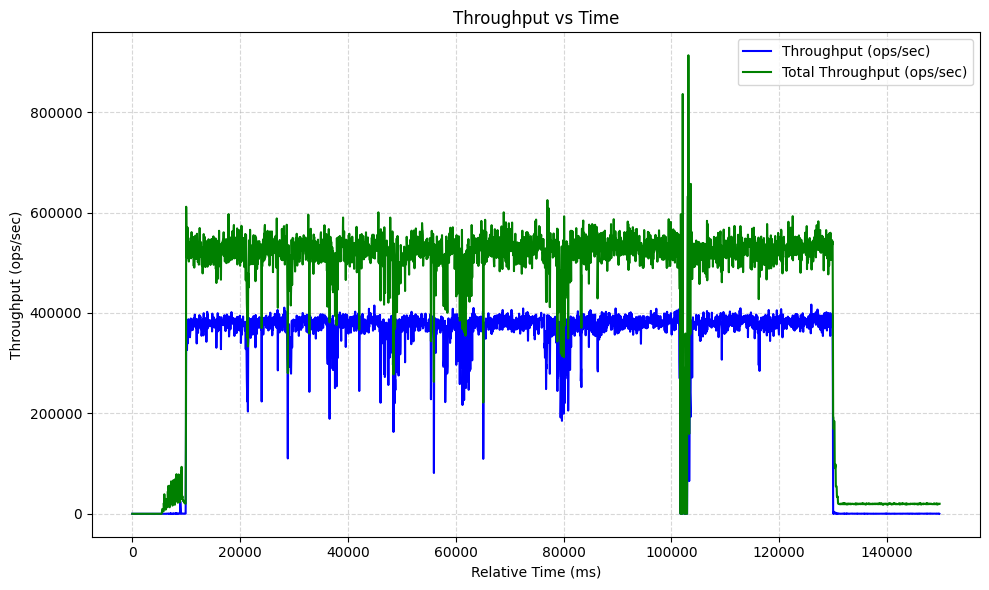

In [19]:
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Helper function to parse timestamps
def parse_timestamp(ts):
    return datetime.strptime(ts, "%H:%M:%S.%f")

# File path
log_file = "../results/emulation_20/order-0.log"

# Regex patterns
tput_pattern = r"\[real-time tput\]: (\d+) ops/sec"
total_tput_pattern = r"\[real-time total tput\]: (\d+) ops/sec"
timestamp_pattern = r"(\d{2}:\d{2}:\d{2}\.\d{6})"

timestamps = []
tput_values = []
total_tput_timestamps = []
total_tput_values = []

with open(log_file, "r") as f:
    for line in f:
        # Extract throughput
        tput_match = re.search(tput_pattern, line)
        total_tput_match = re.search(total_tput_pattern, line)
        timestamp_match = re.search(timestamp_pattern, line)
        
        if tput_match and timestamp_match:
            tput_values.append(int(tput_match.group(1)))
            timestamps.append(parse_timestamp(timestamp_match.group(1)))

        if total_tput_match and timestamp_match:
            total_tput_values.append(int(total_tput_match.group(1)))
            total_tput_timestamps.append(parse_timestamp(timestamp_match.group(1)))

min_timestamp = min(timestamps + total_tput_timestamps)

def to_relative_ms(t):
    return (t - min_timestamp).total_seconds() * 1000

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot throughput
ax.plot([to_relative_ms(t) for t in timestamps], tput_values, label="Throughput (ops/sec)", color="blue")

# Plot total throughput
ax.plot([to_relative_ms(t) for t in total_tput_timestamps], total_tput_values, label="Total Throughput (ops/sec)", color="green")


# Labels and legend
ax.set_xlabel("Relative Time (ms)")
ax.set_ylabel("Throughput (ops/sec)")
ax.set_title("Throughput vs Time")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
# plt.savefig("emulation_tput.png", dpi=600)

mean tput:  299246.81511470984
mean total tput:  418985.15525876463


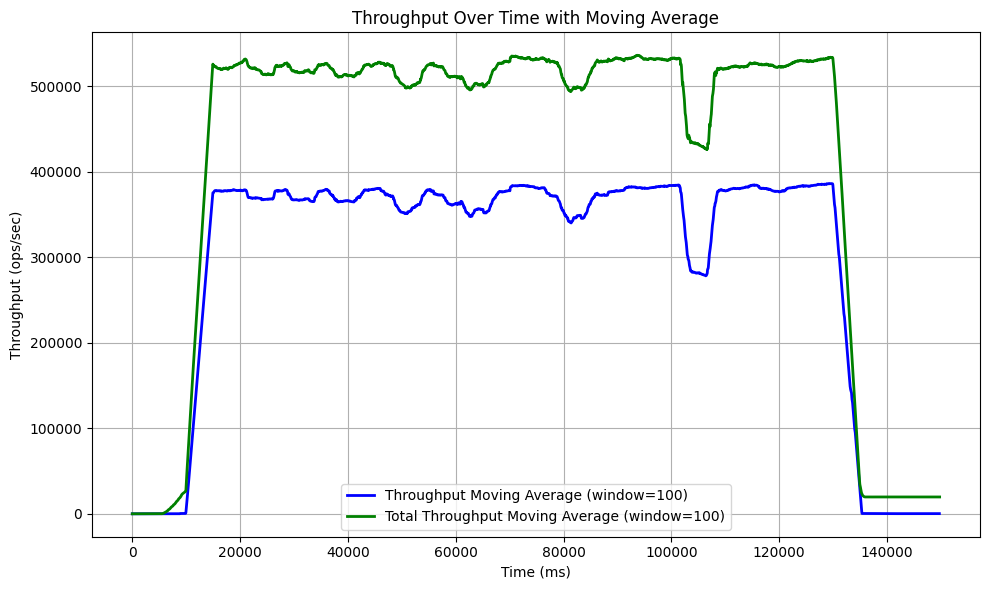

In [ ]:
import pandas as pd

all_timestamps = timestamps + total_tput_timestamps


tput_df = pd.DataFrame({
    'time': timestamps,
    'tput': tput_values,
})

total_tput_df = pd.DataFrame({
    'time': total_tput_timestamps,
    'total tput': total_tput_values,
})

tput_df = tput_df.sort_values(by='time')
total_tput_df = total_tput_df.sort_values(by='time')

# CONFIGURE WINDOW SIZE HERE
window_size = 100  # Set the window size for the moving average
tput_df['moving_avg'] = tput_df['tput'].rolling(window=window_size, min_periods=1).mean()
total_tput_df['moving_avg'] = total_tput_df['total tput'].rolling(window=window_size, min_periods=1).mean()

min_time = min(all_timestamps)

tput_df['relative_time_ms'] = (tput_df['time'] - min_time).dt.total_seconds() * 1000
total_tput_df['relative_time_ms'] = (total_tput_df['time'] - min_time).dt.total_seconds() * 1000

plt.figure(figsize=(10, 6))
plt.plot(tput_df['relative_time_ms'], tput_df['moving_avg'], label=f'Throughput Moving Average (window={window_size})', color='blue', linewidth=2)
plt.plot(total_tput_df['relative_time_ms'], total_tput_df['moving_avg'], label=f'Total Throughput Moving Average (window={window_size})', color='green', linewidth=2)

plt.xlabel('Time (ms)')
plt.ylabel('Throughput (ops/sec)')
plt.title('Throughput Over Time with Moving Average')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("emulation_20.png", dpi=600)

## print average throughput metrics


In [21]:
import os
import re
import fnmatch

def average_emulation_metrics(directory):
    """
    Calculates the average of the `mean`, `p50`, and `p99` metrics across all files in a directory matching the pattern `data*.log`.

    Args:
        directory (str): Path to the directory containing log files.

    Returns:
        dict: A dictionary containing the averages of `mean`, `p50`, and `p99` metrics.
    """
    data_regex = re.compile(r"(mean|p50|p99),\s*([\d.e+-]+),\s*([\d.e+-]+)")
    
    append_metrics = {"mean": [], "p50": [], "p99": []}
    delivery_metrics = {"mean": [], "p50": [], "p99": []}

    for filename in os.listdir(directory):
        if fnmatch.fnmatch(filename, 'data*.log'):  
            filepath = os.path.join(directory, filename)
            
            with open(filepath, 'r') as file:
                for line in file:
                    match = data_regex.search(line)
                    if match:
                        metric, append_latency, delivery_latency = match.groups()
                        append_metrics[metric].append(float(append_latency))
                        delivery_metrics[metric].append(float(delivery_latency)) 
    
    averages = {
        "append": {metric: sum(values) / len(values) for metric, values in append_metrics.items()},
        "delivery": {metric: sum(values) / len(values) for metric, values in delivery_metrics.items()}
    }
    
    return averages


In [ ]:
# Define input directory
input_directory = "../results/emulation_20"

# Calculate averages
averages = average_emulation_metrics(input_directory)

# Print the results
print("append/confirmation latency (us):")
print(f"mean: {averages['append']['mean']}")
print(f"p50: {averages['append']['p50']}")
print(f"p99: {averages['append']['p99']}")

print("delivery latency (us):")
print(f"mean: {averages['delivery']['mean']}")
print(f"p50: {averages['delivery']['p50']}")
print(f"p99: {averages['delivery']['p99']}")

append/confirmation latency (us):
mean: 4242.722637798589
p50: 4054.425
p99: 8795.175
delivery latency (us):
mean: 107.23994700574224
p50: 59.575
p99: 425.275
mean throughput (ops/sec):  299246.81511470984
mean total throughput (ops/sec):  418985.15525876463
